# Visualize models' performance on Test data

In [1]:
import os
import yaml

import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import seaborn

#local
import tools

### Load model and config's

In [2]:
# Load config params
params = yaml.load( open(os.getcwd() + '/config.yaml'), yaml.Loader ) 

In [3]:
# Once params are loaded, load TensorFlow and set its GPU config
import tensorflow as tf
tools.set_gpu_configurations(params) 

Setting GPU configurations.


In [4]:
# Load trained model
model = tf.keras.models.load_model(os.getcwd() + '/saved_models/' + params['model_name'] +'.h5') 
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                20992     
_________________________________________________________________
dense (Dense)                (None, 28)                1820      
Total params: 22,812
Trainable params: 22,812
Non-trainable params: 0
_________________________________________________________________


In [5]:
#List all Test observations
filenames = os.listdir(os.getcwd() + '/data_processed/Test/') 
if 'readme_test.md' in filenames: filenames.remove('readme_test.md') 
if '.gitignore' in filenames: filenames.remove('.gitignore') 

print(f'Found {len(filenames)} Test observations') 

Found 115084 Test observations


### Calculate prediction errors and inspect results

The metric employed is Mean Absolute Error (MAE).

In [6]:
E = [] 
for i in tqdm(range(len(filenames))):
    x = np.load('{}/data_processed/Train/{}'.format(os.getcwd(), filenames[i]), allow_pickle=True) 
    x = tools.RNN_multivariate_processing(array=x, len_input = params['len_input'] + params['len_prediction'])
    
    # Cut input and target out of data batch
    if params['model_type'] == 1:
        y = x[ : , -params['len_prediction']: , 0 ]
        x = x[ : , :-params['len_prediction'] , : ]
    if params['model_type'] == 2:
        y = x[ : , params['len_prediction']: , 0:1 ] 
        x = x[ : , :-params['len_prediction'] , : ] 
    
    p = model.predict(x)

    if p.shape[1] > y.shape[1]:
        p = p[:,0:y.shape[1]]

    error_mae = np.abs(y - p) 
    error_mae = np.mean(error_mae, axis=1) 
    E.extend(error_mae) 

100%|██████████| 115084/115084 [3:28:37<00:00,  9.19it/s] 


In [9]:
# Compute some univariate stats on that
error_min = np.min(E)
error_25p = np.percentile(E, 25)
error_mean = np.mean(E)
error_std = np.std(E)
error_median = np.median(E)
error_75p = np.percentile(E, 75)
error_max = np.max(E)

print('\nError statistics:')
print('\tMean:           ', error_mean)
print('\tSt dev:         ', error_std, '\n')
print('\tMin:            ', error_min)
print('\t25th percentile:', error_25p)
print('\tMedian:         ', error_median)
print('\t75th percentile:', error_75p)
print('\tMax:            ', error_max)


Error statistics:
	Mean:            0.041500323
	St dev:          0.027638666 

	Min:             0.0037169755
	25th percentile: 0.024194985162466764
	Median:          0.035172228
	75th percentile: 0.05019258428364992
	Max:             0.84007066


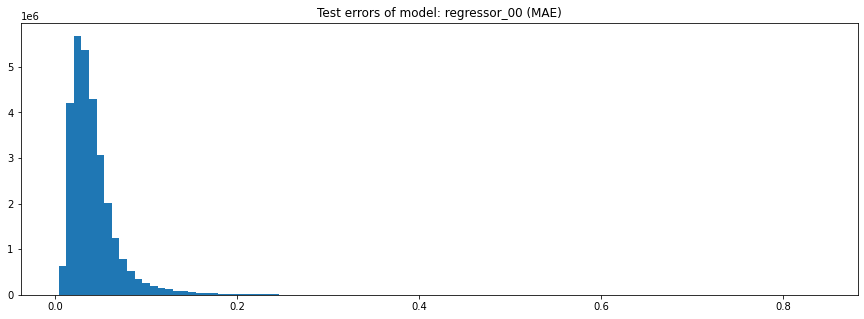

In [14]:
plt.figure(figsize=(15,5))
plt.hist(E, bins=100)
plt.title(f'Test errors of model: '+params['model_name']+' (MAE)')
plt.show() 

### Visual check of model predictions

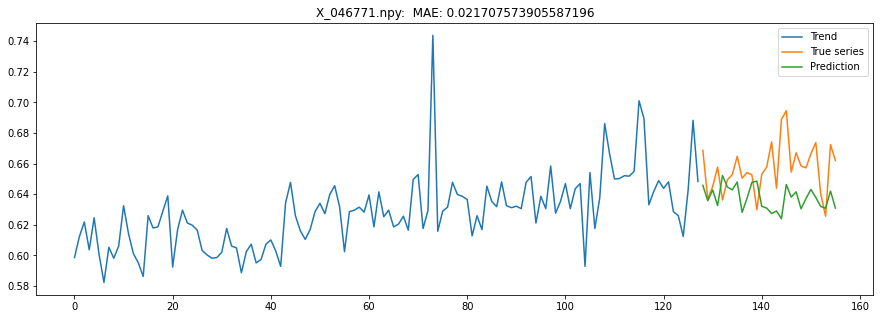

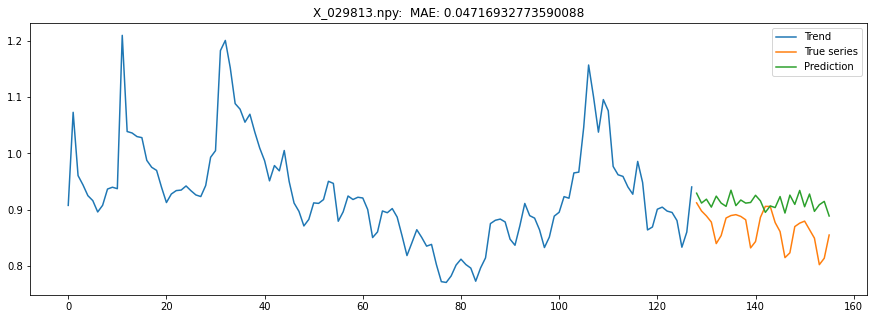

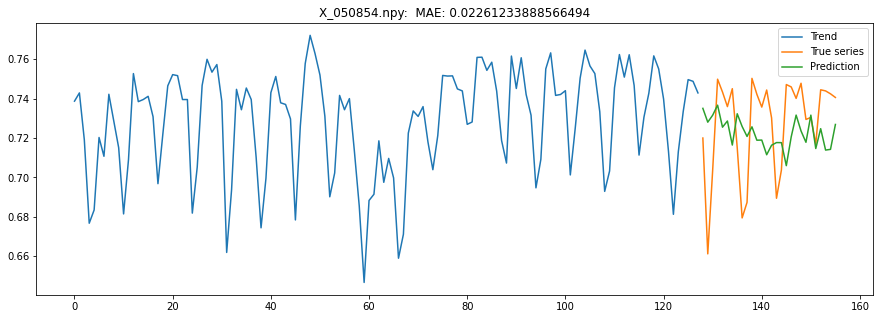

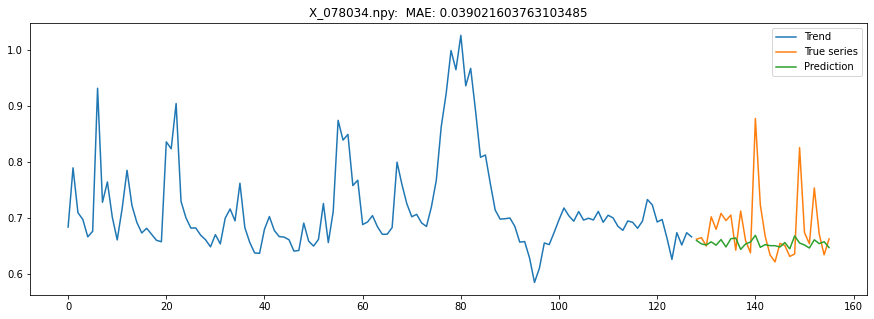

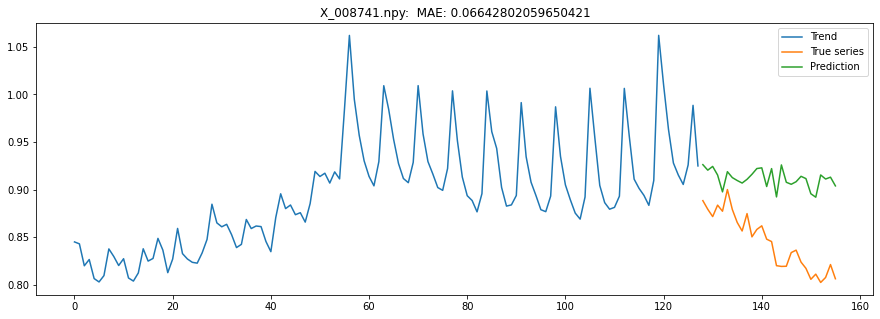

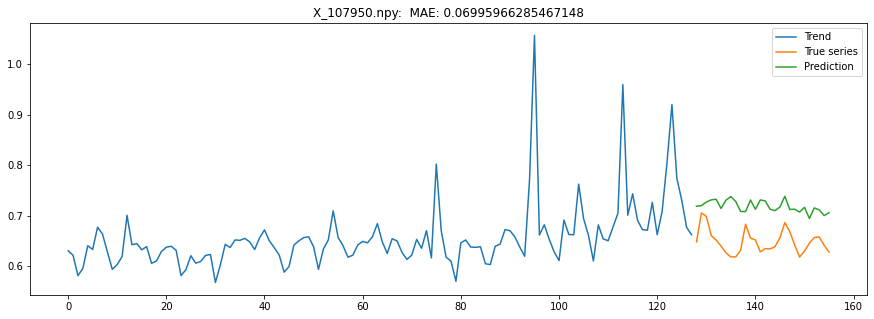

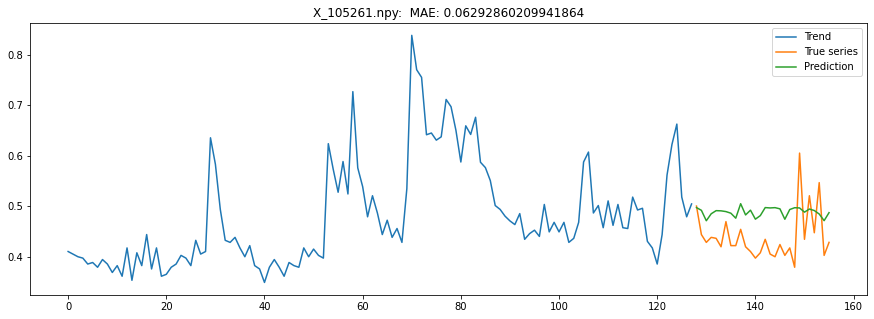

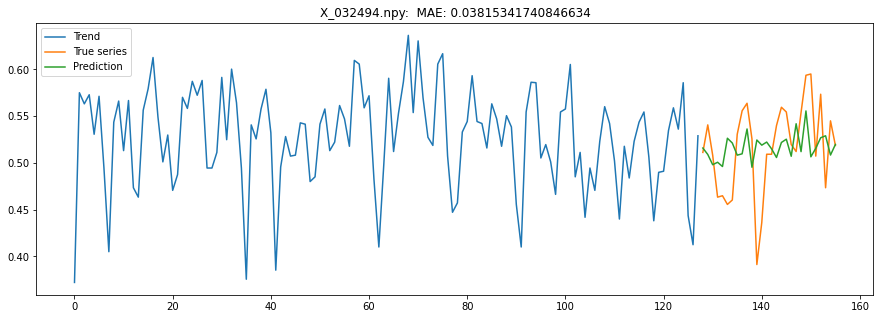

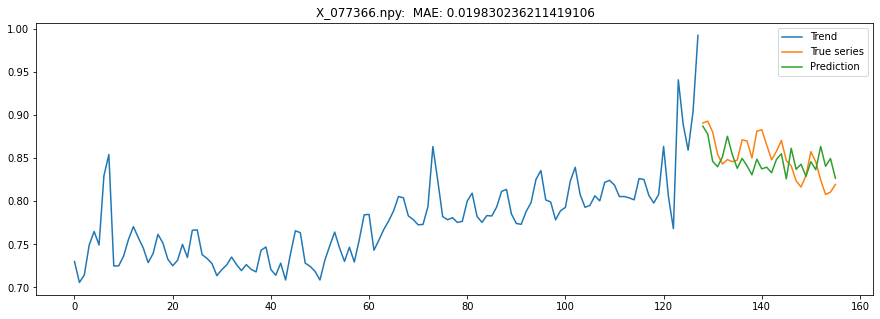

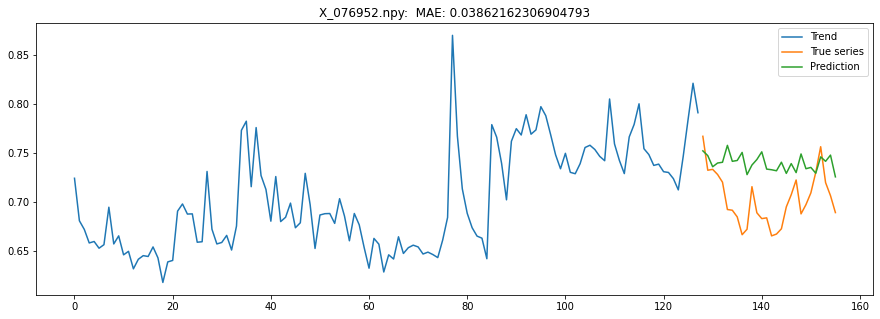

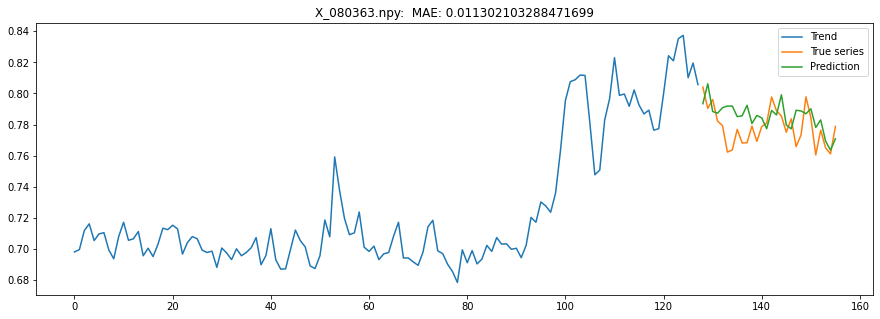

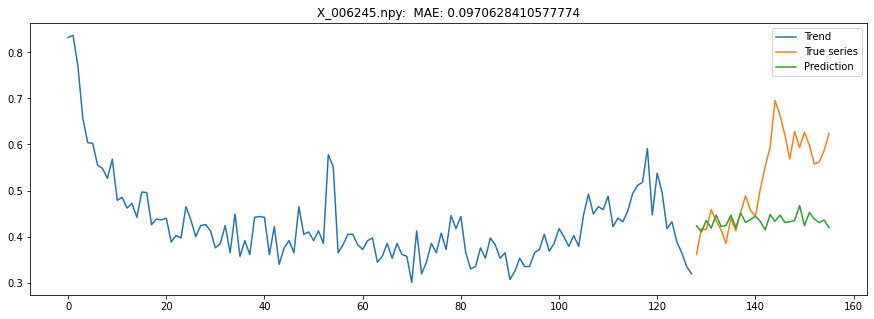

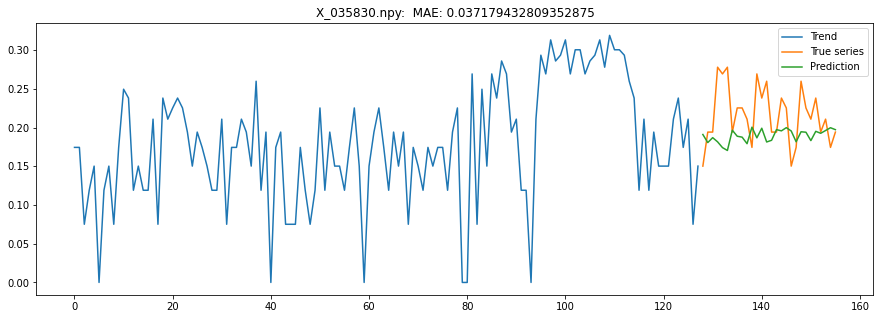

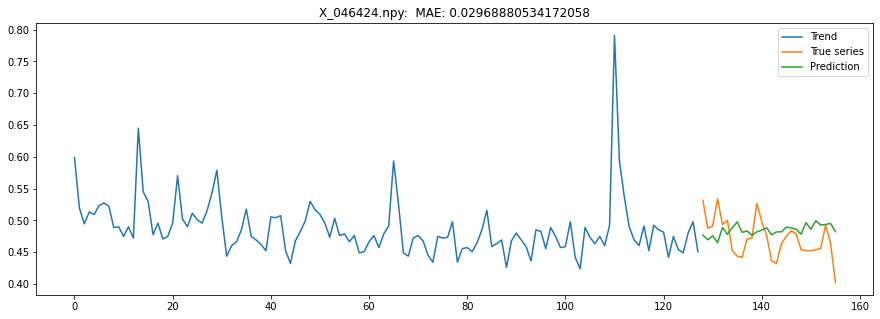

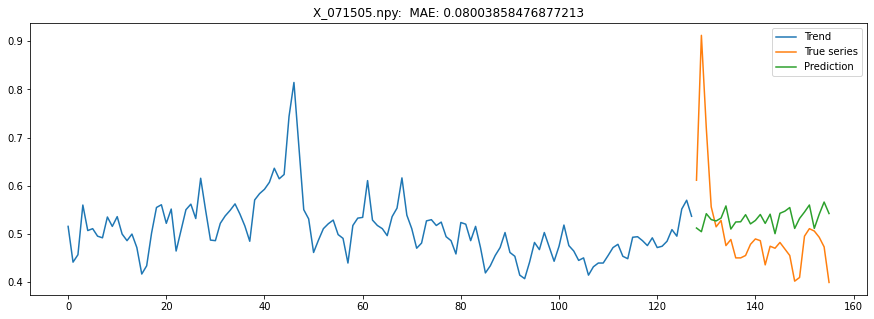

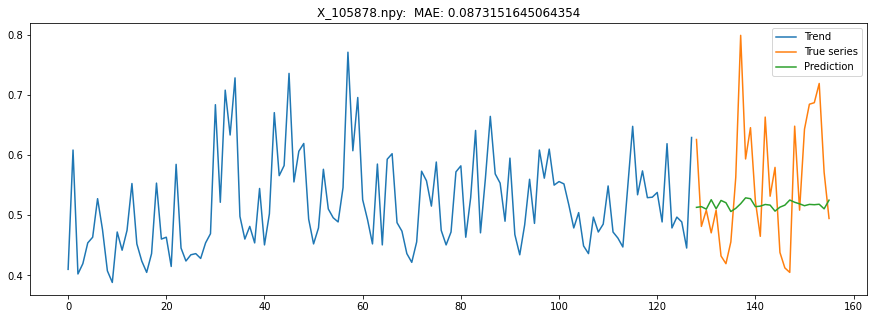

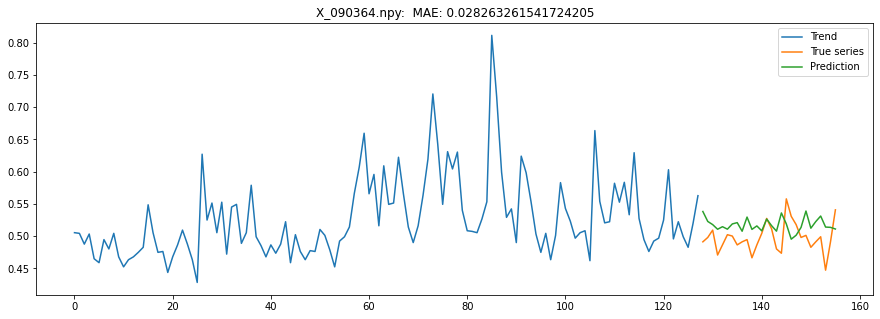

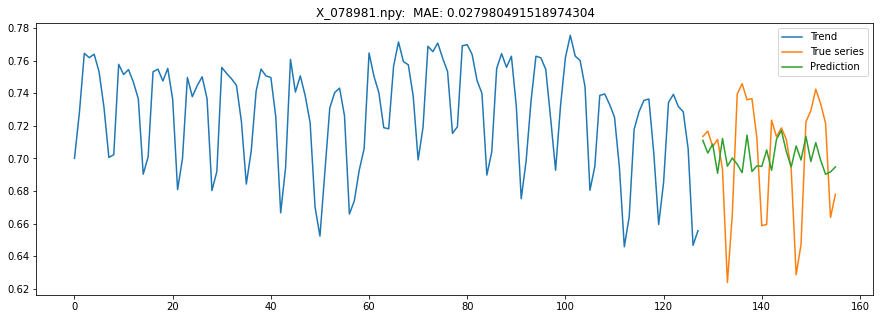

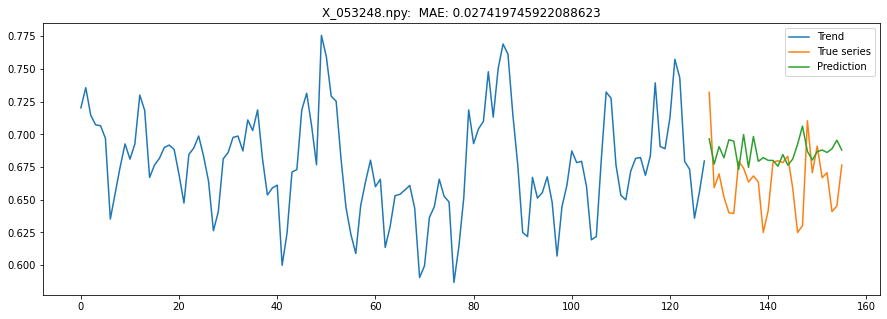

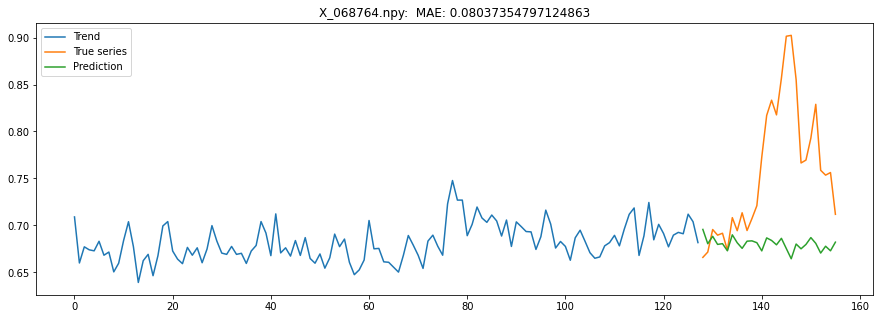

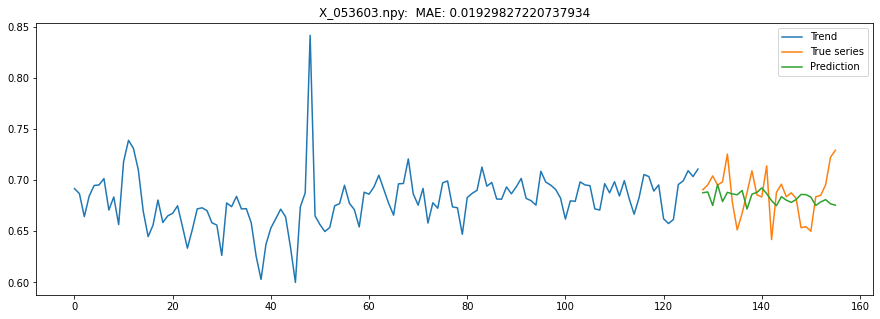

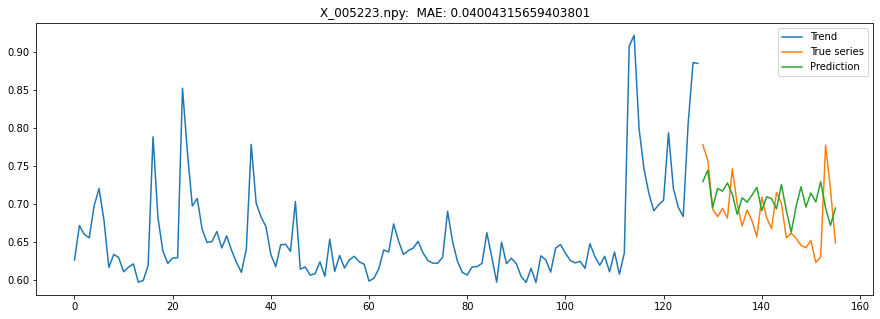

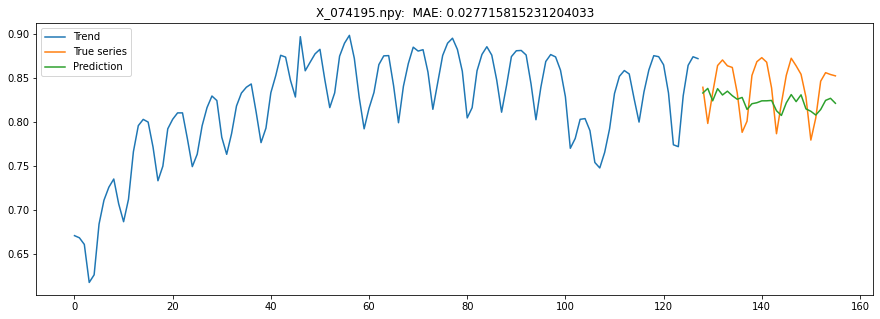

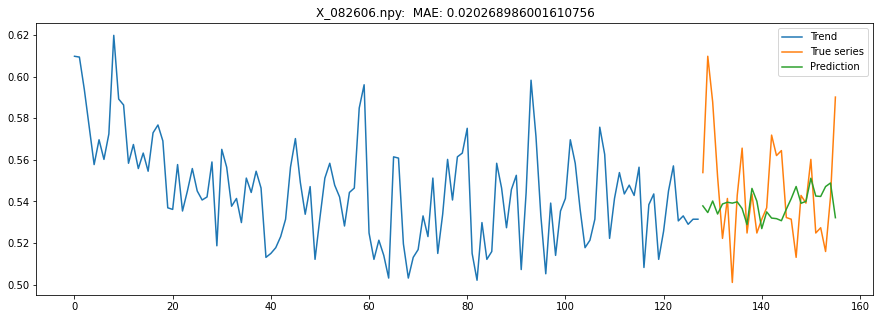

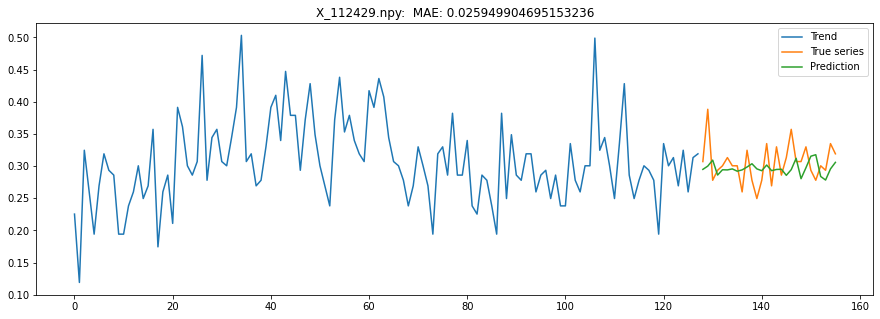

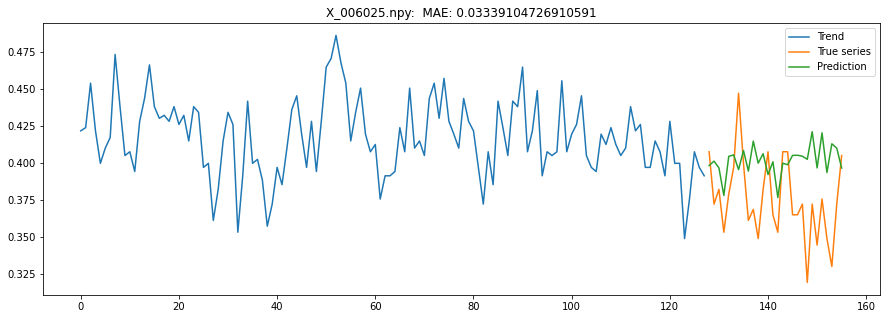

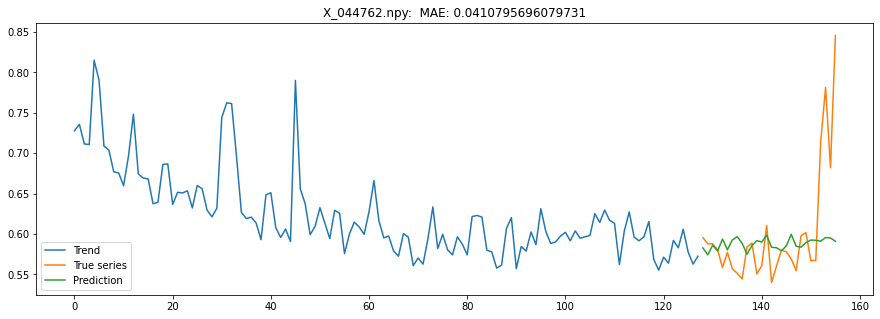

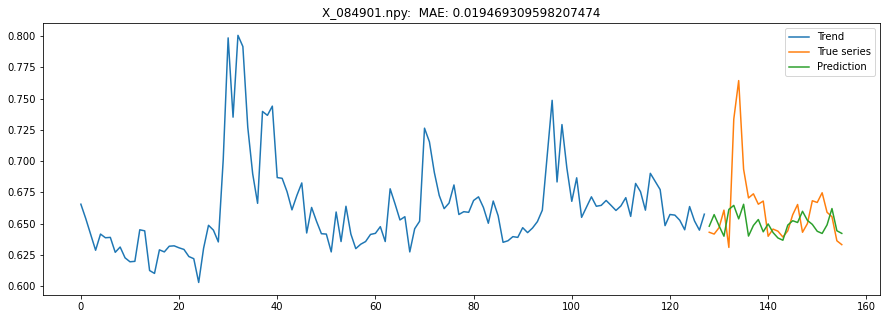

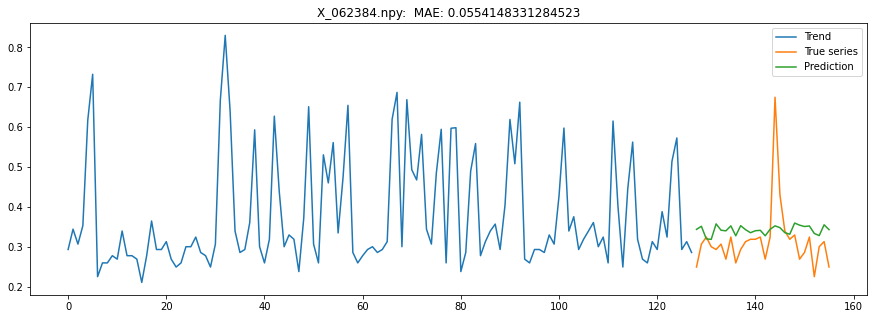

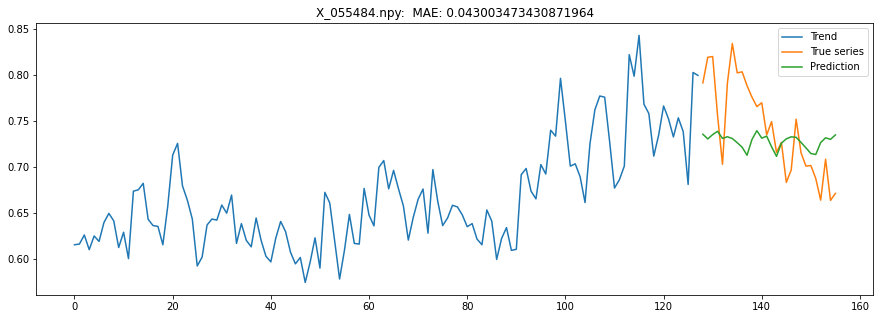

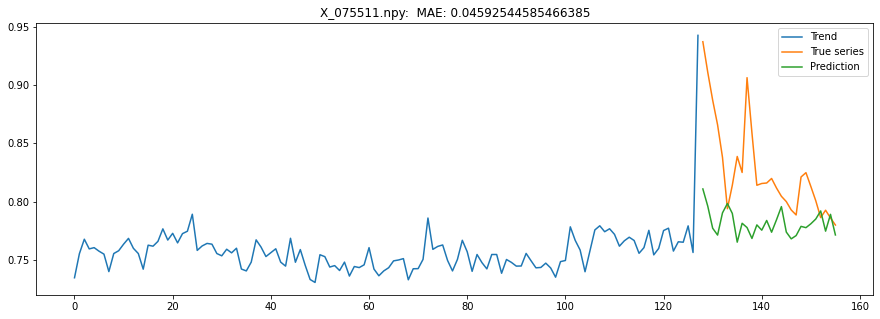

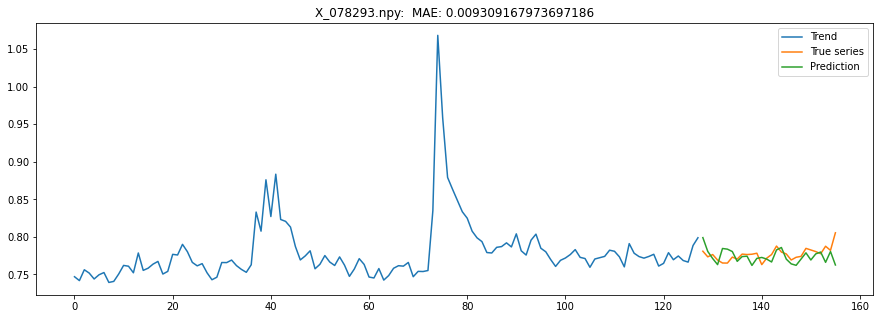

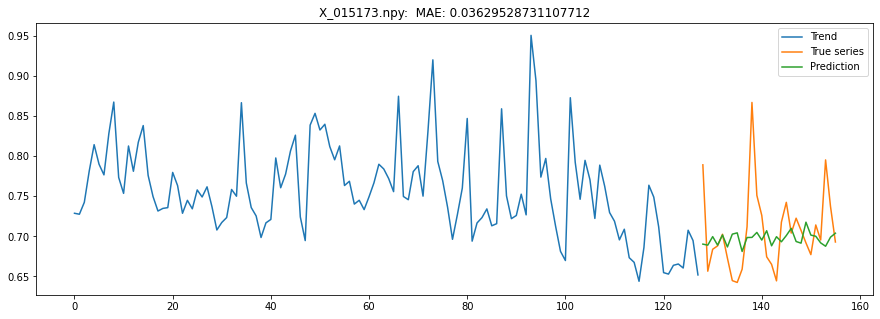

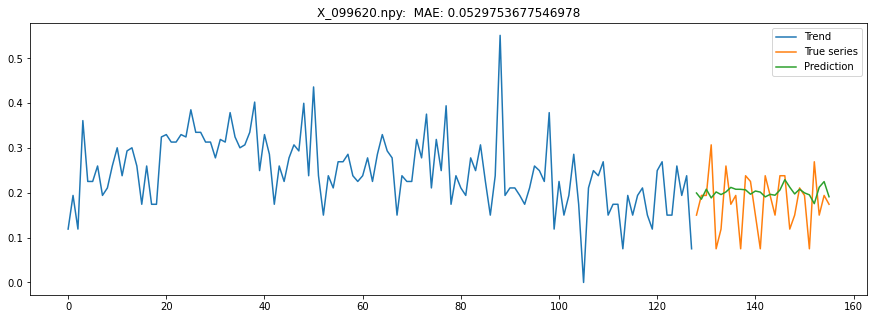

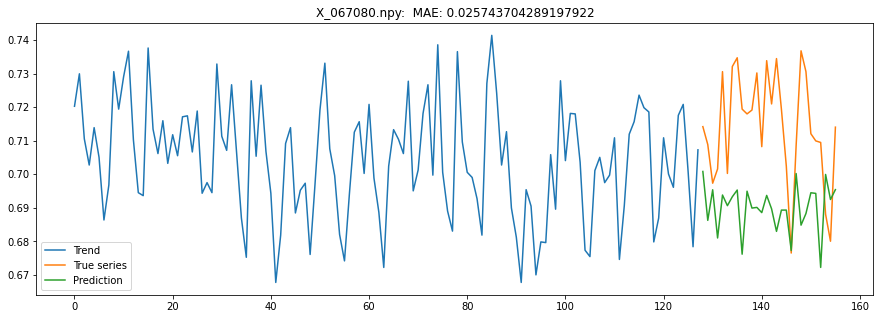

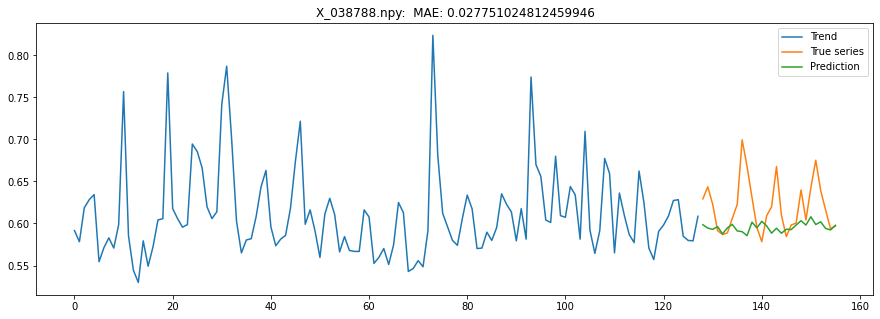

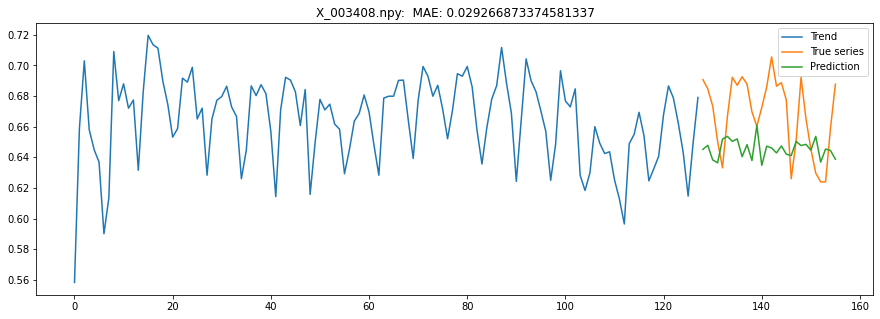

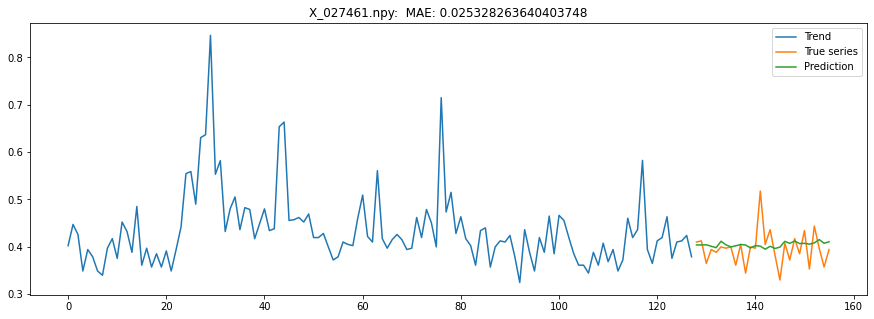

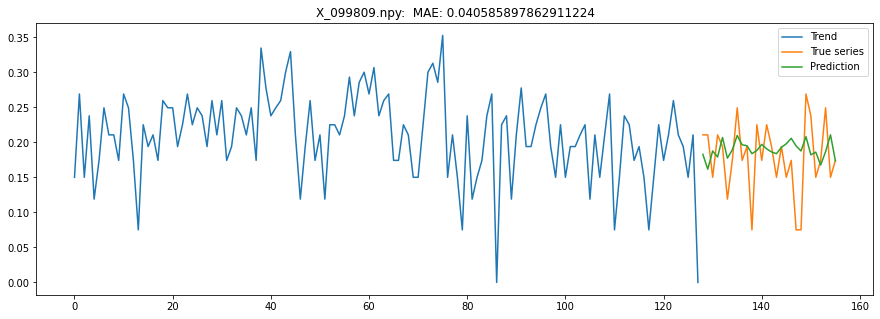

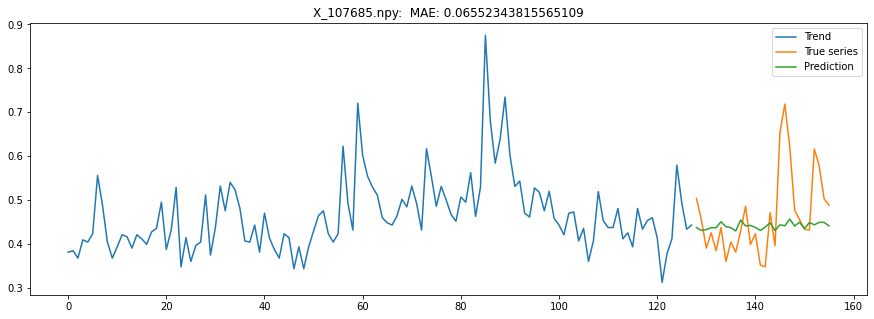

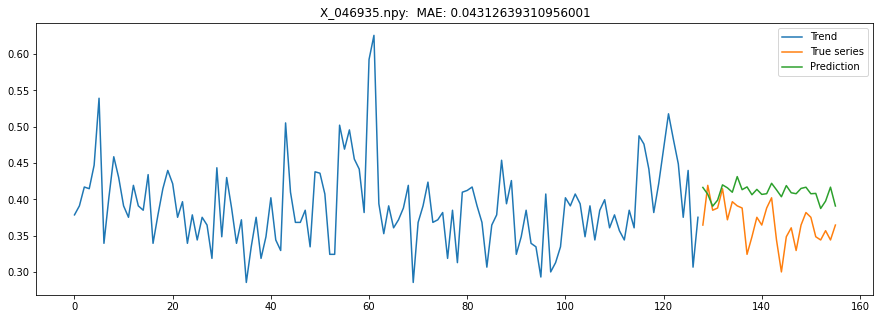

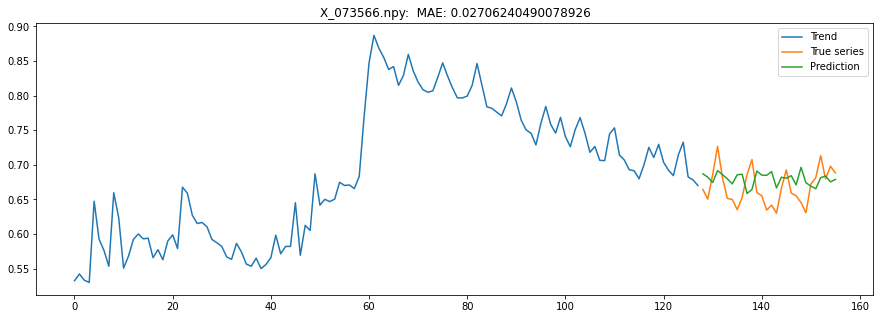

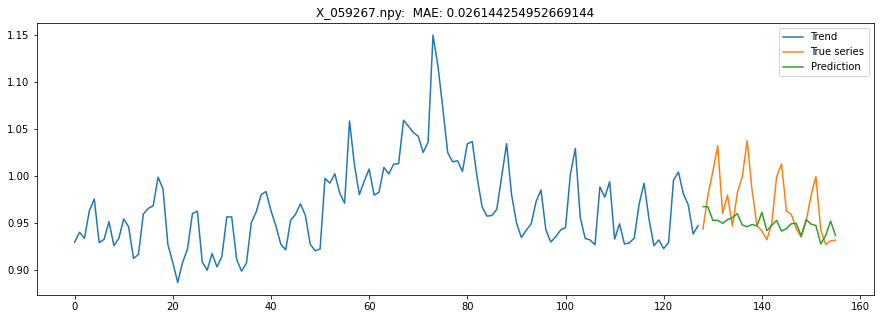

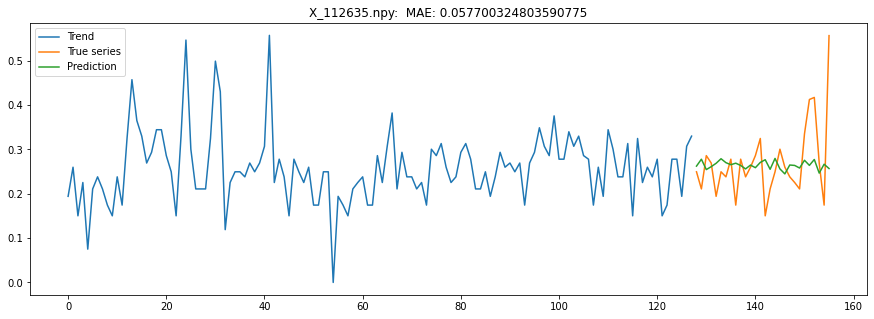

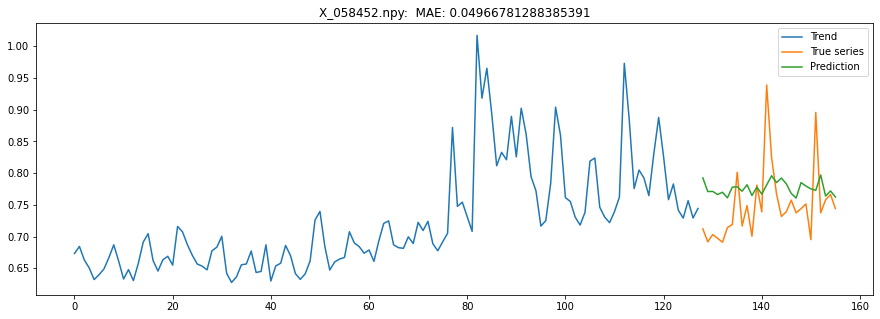

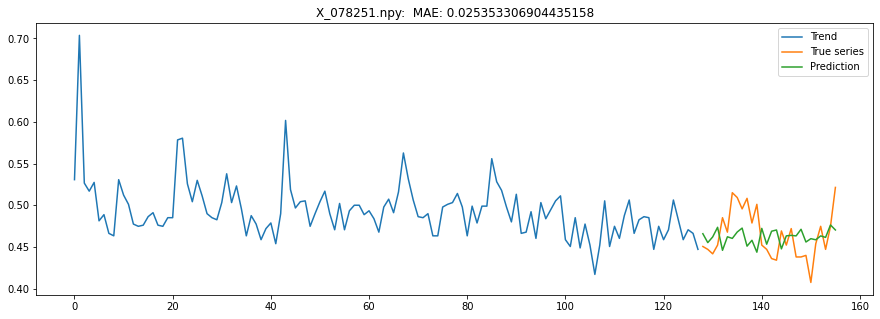

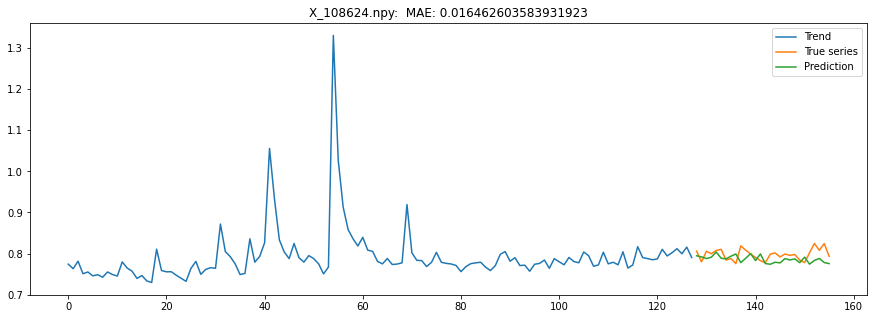

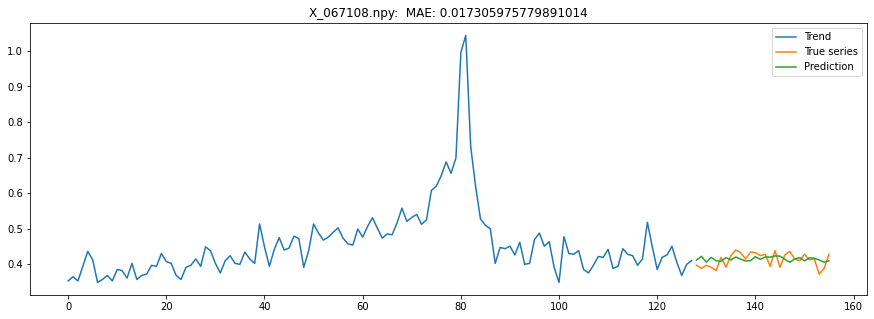

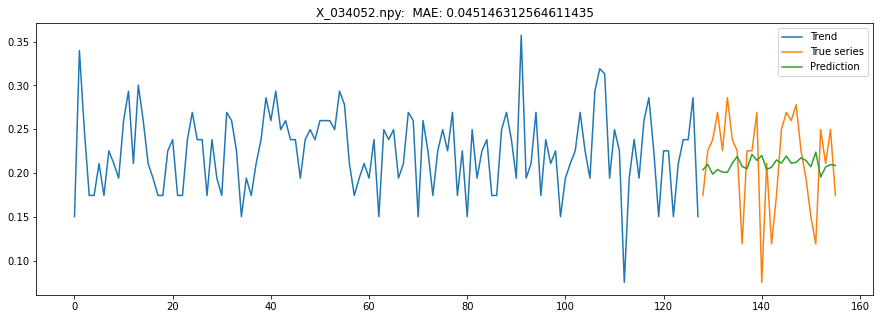

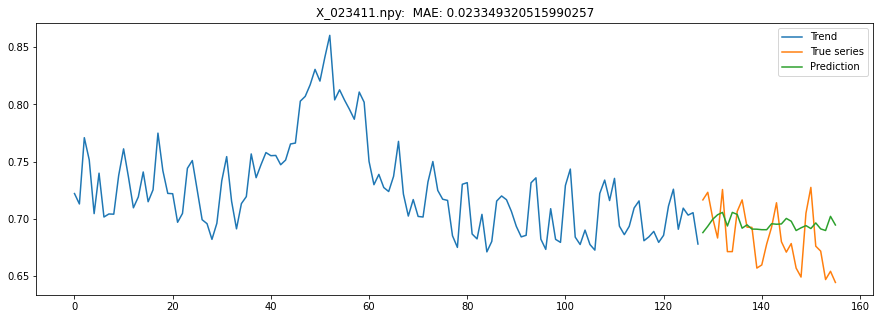

In [17]:
# Sample 50 Test observations
sample = np.random.choice(len(filenames), size=50, replace=False)
test_sample = np.array(filenames)[sample] 

for filename in test_sample:
    x = np.load('{}/data_processed/Train/{}'.format(os.getcwd(), filename), allow_pickle=True) 
    x = tools.RNN_multivariate_processing(array=x, len_input = params['len_input'] + params['len_prediction'])
    
    if params['model_type'] == 1:
        y = x[ : , -params['len_prediction']: , 0 ]
        x = x[ : , :-params['len_prediction'] , : ]
    if params['model_type'] == 2:
        y = x[ : , params['len_prediction']: , 0:1 ] 
        x = x[ : , :-params['len_prediction'] , : ] 
    
    sample = np.random.choice(x.shape[0])
    x = x[sample]
    y = y[sample]

    p = model.predict(np.expand_dims(x, axis=0))
    p = np.squeeze(p)

    error_mae = np.mean(np.abs(y - p))
    
    plt.figure(figsize=(15,5)) 
    plt.plot(x[:,0], label='Trend')
    plt.plot([np.nan]*len(x) + list(y), label='True series')
    plt.plot([np.nan]*len(x) + list(p), label='Prediction')
    plt.title('{}:  MAE: {}'.format(filename, error_mae)) 
    plt.legend() 
    plt.show() 